In [12]:
import networkx as nx
import numpy as np
import random
from collections import deque
from multiprocessing import Pool
import matplotlib.pyplot as plt

import spectral_embedding as spe
from data import test_data
import preprocessing
H = random.choice(list(test_data.values()))

In [13]:
def kelmans_op(G, u, v):
    if not G.has_edge(u,v):
        print("uv not in E(G), cannot perform kelmans")
        return G.copy()
    H = G.copy()
    for w in list(H.neighbors(u)):
        if w!=v and not H.has_edge(v,w):
            H.add_edge(v,w)
            H.remove_edge(u,w)
    return H

In [14]:
def select_kelmans_candidate(G):
    best_score = -1
    best_edge = None
    for u,v in G.edges():
        neighbors_u = set(G.neighbors(u))
        neighbors_v = set(G.neighbors(v))
        # kelmans u->v: les voisins de u pas attaches a v se detache de u pr s'attacher a v
        # donc la 'magnitude' de changement par u->v est les voisins de u qui ne sont pas dans le voisinage de v: N(u) - N(v)
        # d'un autre cote, 
        transferable_uv = len(neighbors_u-neighbors_v)
        transferable_vu = len(neighbors_v-neighbors_u)
        deg_u = G.degree(u)
        deg_v = G.degree(v)
        score_uv = transferable_uv*max(deg_u-deg_v, 0)/deg_u
        score_vu = transferable_vu*max(deg_v-deg_u,0)/deg_v
        if score_uv > best_score:
            best_score = score_uv
            best_edge = (u, v)
        if score_vu > best_score:
            best_score = score_vu
            best_edge = (v, u)
    return best_edge

In [15]:
def ugly_graph(G, removal_prob=0.7):
    H = G.copy()
    edges = list(H.edges())
    for u,v in edges:
        if np.random.rand() < removal_prob:
            H.remove_edge(u,v)
    padded_H = preprocessing.pad_pendents(H)
    return padded_H

def test_graph(n):
    G = nx.complete_graph(n)
    G_ugly = ugly_graph(G)
    #pos = nx.spring_layout(G_ugly)
    #nx.draw(G_ugly, pos, with_labels=True, node_color='green', edge_color='black')
    #plt.title(f"uglied graph on {n} vertices")
    #plt.show()
    return G_ugly

In [16]:
test_graph(10)

In [24]:
def test_convergence(shifted, best_edge):
    if shifted is None:
        return False
    u,v = shifted
    return v, u == best_edge

def kelmans_bis(G, shifted, i, maxiter=10):
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='green', edge_color='black')
    if shifted is None:
        plt.title(f"original graph")
    else:
        plt.title(f"iteration {i}")
    plt.show()
    if i==maxiter:
        return G
    else:
        best_edge = select_kelmans_candidate(G)
        if test_convergence(shifted, best_edge):
            print("method converged: no further changes with optimal kelmans selection")
            return G
        else:
            print("selected optimal candidate edge for kelmans:", best_edge)
            G_refined = kelmans_op(G, *best_edge)
            kelmans_bis(G_refined, best_edge, i+1, maxiter)

def test_kelmans(n, maxiter=10):
    G = test_graph(n)
    refined_G = kelmans_bis(G,None,0, maxiter)
    return refined_G

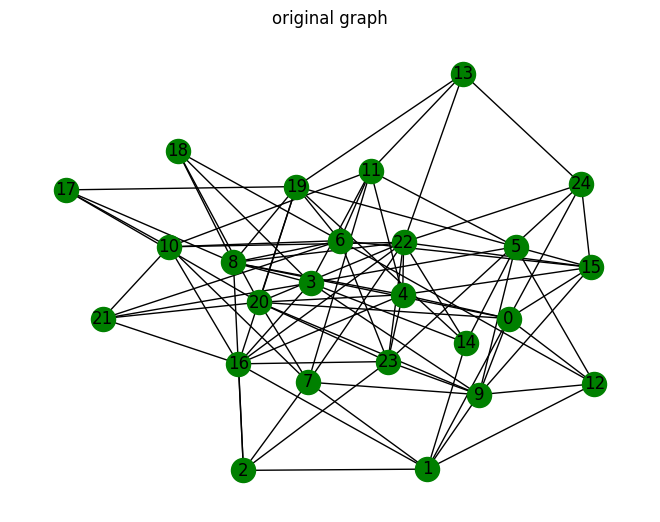

selected optimal candidate edge for kelmans: (22, 13)


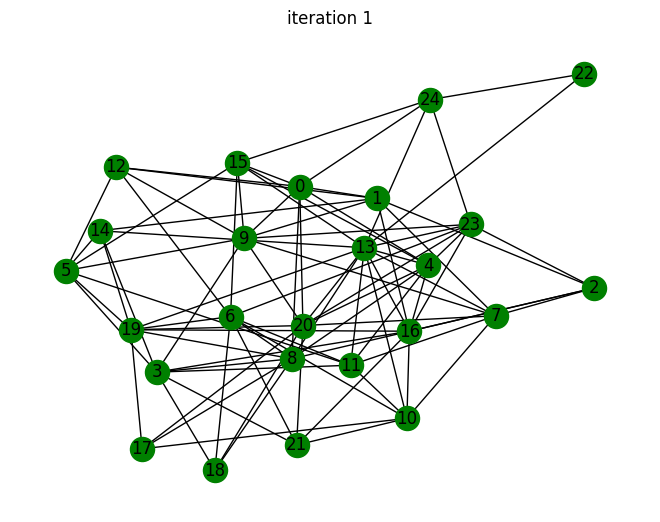

method converged: no further changes with optimal kelmans selection


In [25]:
test_kelmans(25, 5)

In [19]:
def bondy_chvatal_closure(G):
    n = G.number_of_nodes()
    nodes = list(G.nodes())
    neighbor = {node : set(G.neighbors(node)) for node in G.nodes()}
    all_nodes = set(nodes)
    non_neighbors = {node : all_nodes - neighbor[node] - {node} for node in G.nodes()}
    queue = deque(nodes)
    in_queue = {u: True for u in nodes}
    while queue:
        u = queue.popleft()
        in_queue[u] = False
        for v in list(non_neighbors[u]):
            if len(neighbor[u] & neighbor[v]) > n:
                neighbor[u].add(v)
                neighbor[v].add(u)
                non_neighbors[u].remove(v)
                non_neighbors[v].remove(u)
                if not in_queue[u]:
                    queue.append(u)
                    in_queue[u] = True
                if not in_queue[v]:
                    queue.append(v)
                    in_queue[v] = True
    print("closure complete")
    H = nx.Graph()
    for u in neighbor:
        for v in neighbor[u]:
            if u < v:
                H.add_edge(u, v)
    return H


In [20]:
def test_cl(n):
    G = test_graph(n)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='green', edge_color='black')
    plt.title(f"original graph $G$ on {n} vertices")
    plt.show()
    clG = bondy_chvatal_closure(G)
    pos = nx.spring_layout(clG)
    nx.draw(clG, pos, with_labels=True, node_color='green', edge_color='black')
    plt.title(f"closed $G$")
    plt.show()
    return clG

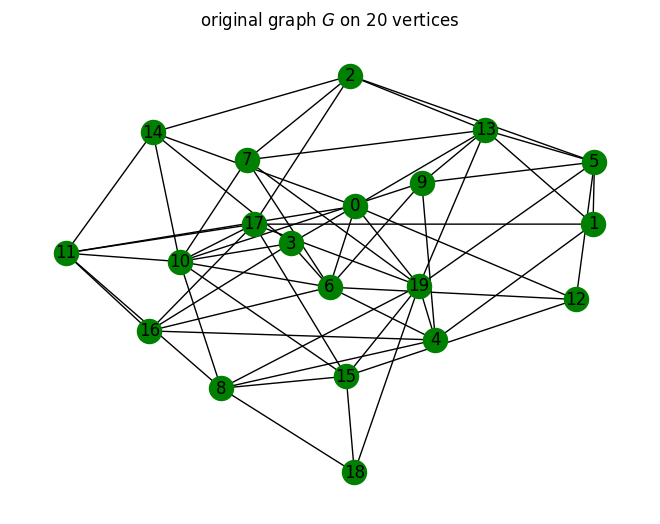

closure complete


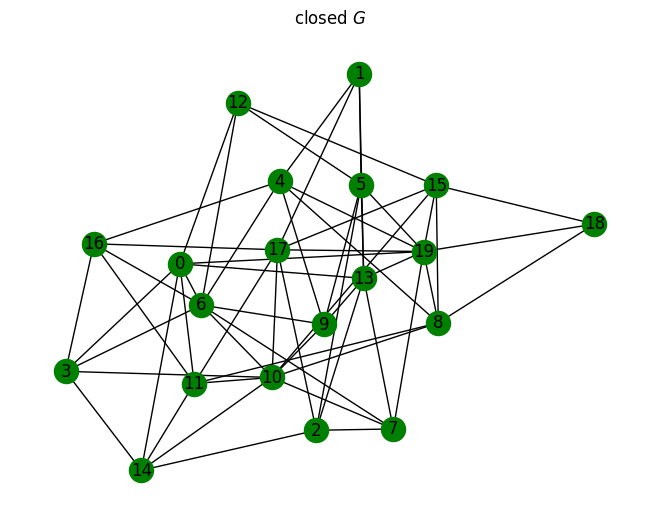

In [21]:
test_cl(20)

In [26]:
# pr l'instant le kelmans est moins que satisfaisant --> on veut des resultats plus extremes
# le thm de bondy chvatal dit que G hamiltonian <=> cl(G) hamiltonian
# => si cl(H) = cl(G) alors si H hamiltonian alors G hamiltonian
# sous cette condition d'equivalence sous ham on peut + aggressively modify G then put it back together with kelmans into something potentially extremal

In [ ]:
#(keeping just for demonstration)
def closure_equivalence(G1, G2):
    return bondy_chvatal_closure(G1) == bondy_chvatal_closure(G2)
    